# Import Libraries

In [1]:
#!pip install xgboost
import calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve
import xgboost as xgb
from datetime import datetime

# Import Dataset

In [2]:
data = pd.read_csv("startup_data_1.csv")
data.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [3]:
list(data.columns)

['Unnamed: 0',
 'state_code',
 'latitude',
 'longitude',
 'zip_code',
 'id',
 'city',
 'Unnamed: 6',
 'name',
 'labels',
 'founded_at',
 'closed_at',
 'first_funding_at',
 'last_funding_at',
 'age_first_funding_year',
 'age_last_funding_year',
 'age_first_milestone_year',
 'age_last_milestone_year',
 'relationships',
 'funding_rounds',
 'funding_total_usd',
 'milestones',
 'state_code.1',
 'is_CA',
 'is_NY',
 'is_MA',
 'is_TX',
 'is_otherstate',
 'category_code',
 'is_software',
 'is_web',
 'is_mobile',
 'is_enterprise',
 'is_advertising',
 'is_gamesvideo',
 'is_ecommerce',
 'is_biotech',
 'is_consulting',
 'is_othercategory',
 'object_id',
 'has_VC',
 'has_angel',
 'has_roundA',
 'has_roundB',
 'has_roundC',
 'has_roundD',
 'avg_participants',
 'is_top500',
 'status']

# Data Cleaning

In [4]:
# Define the data cleaning function
def clean_data(data):
    
    # Count initial number of rows
    initial_row_count = data.shape[0]
     
    data = (
            # Drop columns that are not needed
            data.drop(columns=["Unnamed: 0", "latitude", "longitude", "id", "Unnamed: 6", 
                               "object_id", "labels", "state_code.1", "closed_at", "state_code", "category_code"])
        
            # Transform status into binary
            .assign(status=lambda x: (x["status"] == "acquired").astype(int)) 
            
            # One-hot encode city and zip_code
            .pipe(pd.get_dummies, columns=['city', 'zip_code'], prefix=['city', 'zip_code']) 
            
            # Convert dates and create new columns
            .assign(founded_at=lambda x: pd.to_datetime(x['founded_at']),
                      first_funding_at=lambda x: pd.to_datetime(x['first_funding_at']),
                      last_funding_at=lambda x: pd.to_datetime(x['last_funding_at']),
                      amt_days_bw_found_first_fund=lambda x: (x['first_funding_at'] - x['founded_at']).dt.days,
                      founding_month=lambda x: x['founded_at'].dt.month) 
            
            # Drop the original date columns
            .drop(columns=['founded_at', 'first_funding_at', 'last_funding_at']) 
            
            # Drop rows with NA values
            .dropna() 
           )
    
    # Calculate the number and percentage of rows dropped
    rows_dropped = initial_row_count - data.shape[0]
    dropped_percentage = (rows_dropped / initial_row_count) * 100

    # Display the number and percentage of rows dropped
    print(f"Dropped {rows_dropped} rows due to missing values ({dropped_percentage:.2f}% of total).")

    # Export the cleaned data
    data.to_csv('1102_startup_data_cleaned.csv', encoding='utf-8', index=False)
    
    return data

# Clean the loaded data
data_clean = clean_data(data)

# Display the shape and columns of the cleaned data
print(f"Data shape: {data_clean.shape}")
#print(f"Data columns: {list(data_clean.columns)}")

Dropped 152 rows due to missing values (16.47% of total).
Data shape: (771, 638)
Data columns: ['name', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'is_top500', 'status', 'city_Acton', 'city_Addison', 'city_Alameda', 'city_Albuquerque', 'city_Aliso Viejo', 'city_Allentown', 'city_Alpharetta', 'city_Altamonte Springs', 'city_Andover', 'city_Annapolis', 'city_Arcadia', 'city_Arlington', 'city_Atlanta', 'city_Austin', 'city_Avon', 'city_Bala Cynwyd', 'city_Bedford', 'city_Bellevue', 'city_Belmont', 'city_Berkeley', 'city_Berwyn', 'city_Bethesda', 'city_Bet

# Preliminary Analysis

<Figure size 1200x800 with 0 Axes>

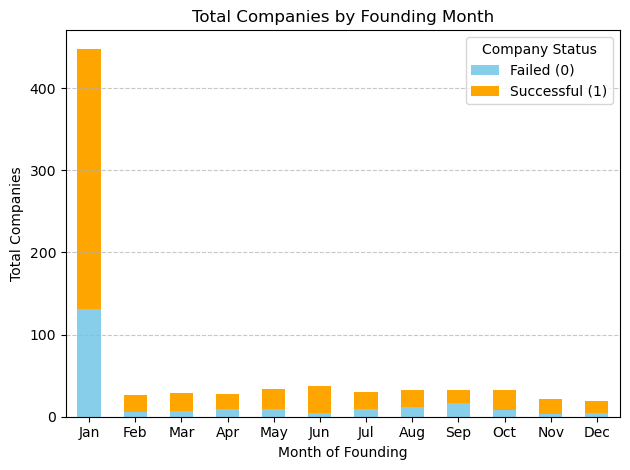

In [5]:
# Plotting without percentages
plt.figure(figsize=(12, 8))
grouped_data = data_clean.groupby('founding_month')['status'].value_counts().unstack().fillna(0)
grouped_data.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])

# Adding labels and title
plt.xlabel('Month of Founding')
plt.ylabel('Total Companies')
plt.title('Total Companies by Founding Month')

# Customizing ticks
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation='horizontal')

# Adding legend and grid
plt.legend(title='Company Status', labels=['Failed (0)', 'Successful (1)'], loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


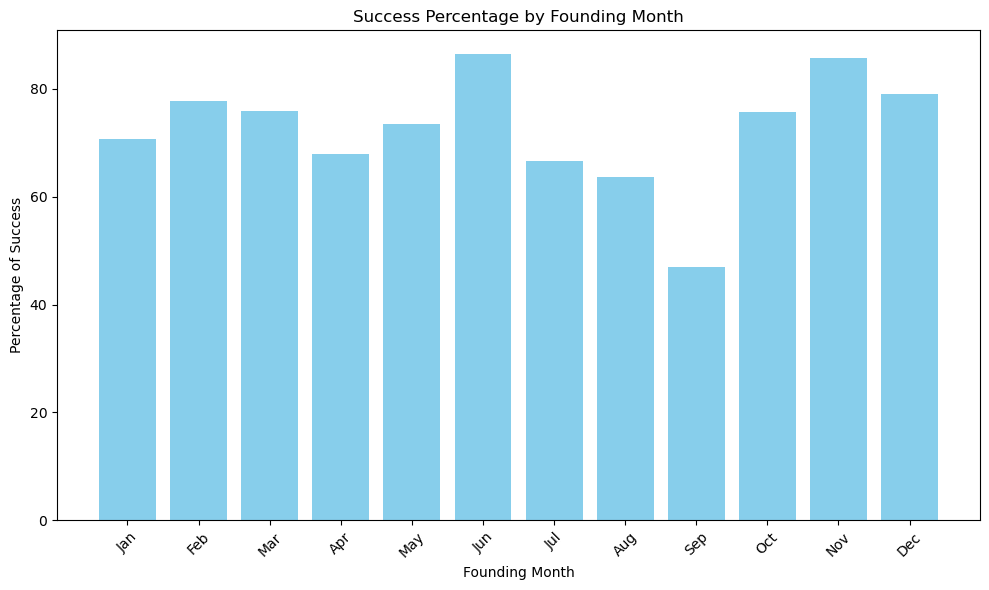

In [6]:
# Rename columns for clarity
grouped_data = grouped_data.rename(columns={0: 'Failures', 1: 'Successes'})

# Calculate the percentage of success
grouped_data['Success Percentage'] = grouped_data.apply(lambda x: 100 * x['Successes'] / (x['Successes'] + x['Failures']), axis=1)

# Reset index to use 'founding_month' as a column
grouped_data = grouped_data.reset_index()

# Assign correct month values
grouped_data['founding_month'] = grouped_data['founding_month'].apply(lambda x: calendar.month_abbr[x])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(grouped_data['founding_month'], grouped_data['Success Percentage'], color='skyblue')

# Adding labels and title
plt.xlabel('Founding Month')
plt.ylabel('Percentage of Success')
plt.title('Success Percentage by Founding Month')

# Ensure all month labels are shown on x-axis
plt.xticks(ticks=range(len(grouped_data['founding_month'])), labels=grouped_data['founding_month'], rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


checking if the month of founding have an effect on the success = No

# Data Preparation

In [7]:
def prepare_data_for_modeling(data_clean, target_column='status', test_size=0.2, random_state=42):
    # Drop columns that are not features
    features = data_clean.drop(columns=[target_column, 'name', 'founding_month'])

    # Separate features (X) and target (y)
    X = features.copy()
    y = data_clean[target_column]

    # Split the dataset into training and testing sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Display class distribution in train and test sets
    print("Training set class distribution:")
    print(y_train.value_counts(normalize=True))  # Normalized value counts for y_train
    print("\nTesting set class distribution:")
    print(y_test.value_counts(normalize=True))  # Normalized value counts for y_test

    return X_train, X_test, y_train, y_test

# Call the function with your data
X_train, X_test, y_train, y_test = prepare_data_for_modeling(data_clean)


Training set class distribution:
1    0.712662
0    0.287338
Name: status, dtype: float64

Testing set class distribution:
1    0.716129
0    0.283871
Name: status, dtype: float64


# Methods

## 1. Sparse Regression

In [8]:
def sparse_regression_classifier(X_train, y_train, X_test, penalty='l1', solver='liblinear', random_state=42):
    
    # Initialize and fit the Lasso Logistic Regression model
    lasso_model = LogisticRegression(penalty=penalty, solver=solver, random_state=random_state)
    lasso_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = lasso_model.predict(X_test)

    # Extract features with non-zero coefficients
    selected_features = X_train.columns[(lasso_model.coef_ != 0).flatten()]
    coefficients = lasso_model.coef_[0][(lasso_model.coef_ != 0).flatten()]

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': coefficients
    })

    # Filter columns to keep based on the model's feature importance
    all_features = list(summary_df['Feature'])
    columns_to_keep_lasso = [
        col for col in all_features if not col.startswith('city_') and not col.startswith('zip_code_')
    ]

    # Create reduced train and test sets based on selected features
    X_train_reduced = X_train[columns_to_keep_lasso]
    X_test_reduced = X_test[columns_to_keep_lasso]

    # Print Lasso selected features and their coefficients
    print("Lasso Selected Features and Coefficients:")
    print(summary_df)

    # Calculate accuracy and other metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of the Lasso model on the test set: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Number of features selected by Lasso
    print(f"Original number of features: {X_train.shape[1]}")
    print(f"Number of features selected by Lasso: {summary_df.shape[0]}")

    # Top features by absolute coefficient value
    top_features = summary_df.sort_values(by='Coefficient', key=abs, ascending=False).head(10)
    print("Top 10 features by absolute coefficient value:")
    print(top_features)

    # Features not selected by Lasso
    non_selected_features = set(X_train.columns) - set(summary_df['Feature'])
    print(f"Features not selected by Lasso: {non_selected_features}")

    return lasso_model, summary_df, X_train_reduced, X_test_reduced

# Call the function with your data
lasso_model, summary_df, X_train_reduced, X_test_reduced = sparse_regression_classifier(X_train, y_train, X_test)

Lasso Selected Features and Coefficients:
                         Feature   Coefficient
0         age_first_funding_year -1.022327e-02
1          age_last_funding_year -1.241580e-02
2       age_first_milestone_year -5.817325e-02
3        age_last_milestone_year  2.384392e-01
4                  relationships  1.351312e-01
5                 funding_rounds -5.755962e-02
6              funding_total_usd -2.788835e-10
7                     milestones -1.632406e-01
8                          is_CA  1.678459e-01
9                    is_software  2.549944e-01
10                        is_web -3.336859e-02
11                 is_gamesvideo -5.711603e-01
12                  is_ecommerce -9.548720e-02
13                    is_biotech  6.405561e-02
14                        has_VC -2.371639e-01
15                     has_angel -3.560002e-01
16                    has_roundA -2.254020e-01
17                    has_roundB -3.120602e-02
18                    has_roundC -4.046781e-01
19                

## 2. XGBoost

In [9]:
def xgb_classifier(X_train, y_train, X_test, y_test, use_proba=True, cv_folds=5):
    
    # Initialize the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(random_state=42)

    # Train the model
    xgb_classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = xgb_classifier.predict(X_test)
    
    # Calculate the probabilities for ROC and Precision-Recall
    if use_proba and len(np.unique(y_test)) == 2:
        y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Calculate and plot ROC Curve and AUC if it's a binary classification task
    if use_proba and len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print("ROC AUC Score:", roc_auc)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(recall, precision, label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="upper right")
        plt.show()

    # Cross-Validation Scores
    cross_val_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=cv_folds)
    print("Cross-Validation Scores:", cross_val_scores)
    print("Mean CV Accuracy:", cross_val_scores.mean())

    # Plot feature importance
    xgb.plot_importance(xgb_classifier)
    plt.show()

    return xgb_classifier

Accuracy: 0.7354838709677419
Confusion Matrix:
 [[18 26]
 [15 96]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.41      0.47        44
           1       0.79      0.86      0.82       111

    accuracy                           0.74       155
   macro avg       0.67      0.64      0.65       155
weighted avg       0.72      0.74      0.72       155

ROC AUC Score: 0.705978705978706


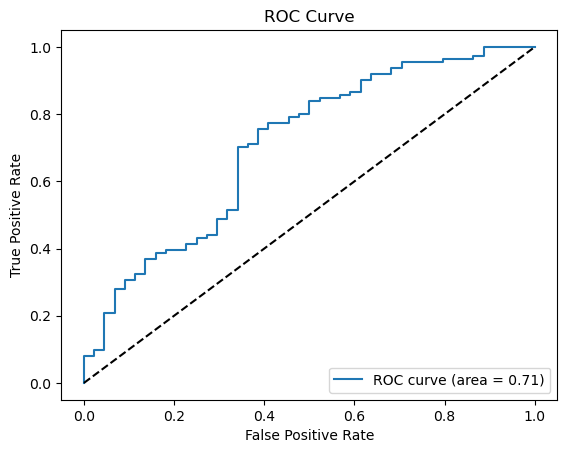

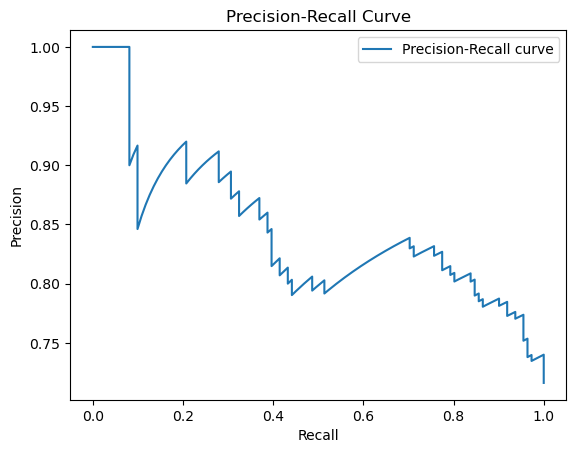

Cross-Validation Scores: [0.77419355 0.75609756 0.76422764 0.80487805 0.77235772]
Mean CV Accuracy: 0.7743509047993706


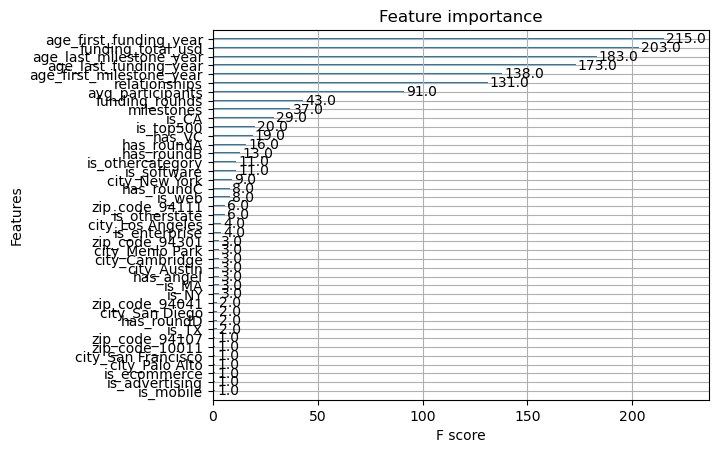

In [10]:
complete_XGB=xgb_classifier(X_train, y_train, X_test, y_test)

Accuracy: 0.7225806451612903
Confusion Matrix:
 [[17 27]
 [16 95]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.39      0.44        44
           1       0.78      0.86      0.82       111

    accuracy                           0.72       155
   macro avg       0.65      0.62      0.63       155
weighted avg       0.70      0.72      0.71       155

ROC AUC Score: 0.678951678951679


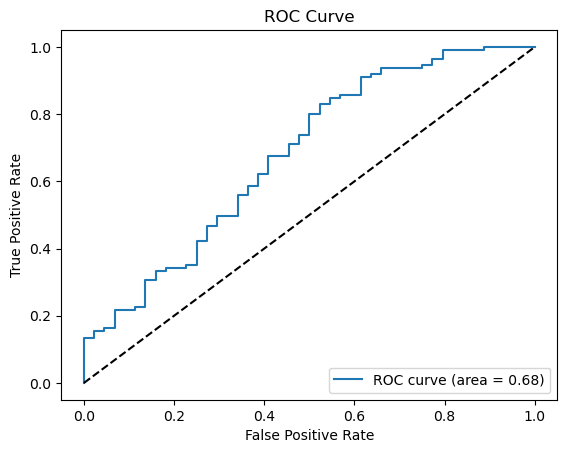

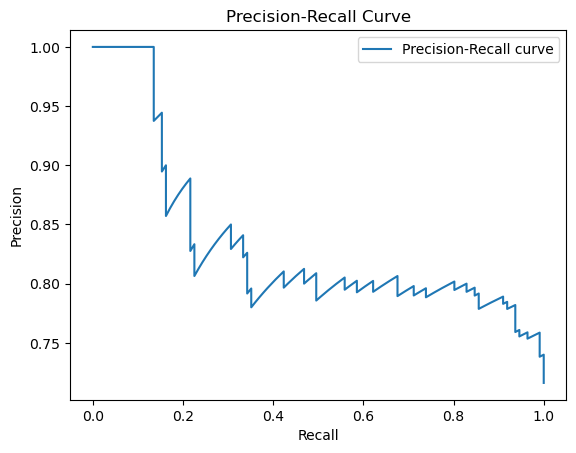

Cross-Validation Scores: [0.76612903 0.78861789 0.76422764 0.78861789 0.78861789]
Mean CV Accuracy: 0.7792420666142145


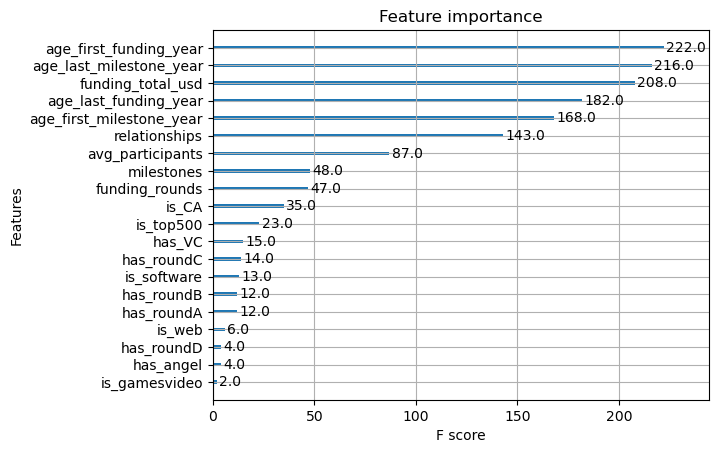

In [11]:
reduced_XGB=xgb_classifier(X_train_reduced, y_train, X_test_reduced, y_test)

## 3. CART

In [12]:
def CART_classifier(X_train, y_train, X_test, y_test):
    
    # Create Decision Tree classifier object
    clf = DecisionTreeClassifier()

    # Train Decision Tree Classifier
    clf = clf.fit(X_train, y_train)

    # Predict the response for the test dataset
    y_pred = clf.predict(X_test)
    
    # Plot Decision Tree
    plt.figure(figsize=(20,10))
    plot_tree(clf, filled=True)
    plt.show()

    # Model Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Classification Report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # ROC-AUC (only for binary classification)
    if len(set(y_test)) == 2:
        y_pred_prob = clf.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("ROC AUC Score:", roc_auc)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    
    # Feature Importances
    feature_importances = clf.feature_importances_
    indices = np.argsort(feature_importances)[-10:]  # Get the indices of the top features
    plt.figure(figsize=(10,10))
    plt.title('Top 10 Feature Importances'.format(10))
    plt.barh(range(len(indices)), feature_importances[indices], color='lightblue', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    # Cross-Validation Scores
    cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5)
    print("Cross-Validation Scores:", cross_val_scores)
    print("Mean CV Accuracy:", cross_val_scores.mean())

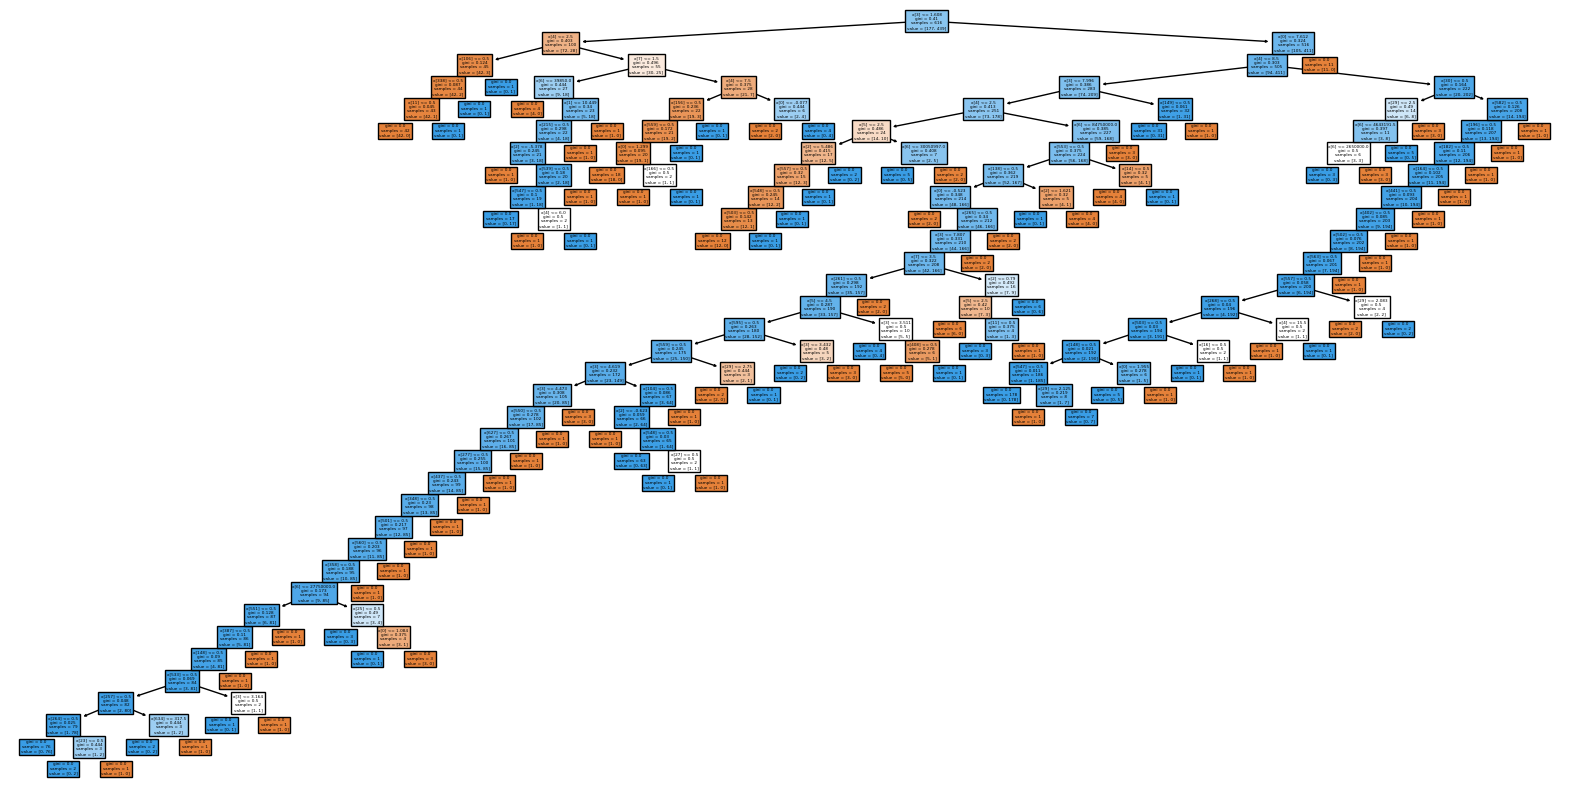

Accuracy: 0.7419354838709677
Confusion Matrix:
 [[22 22]
 [18 93]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.50      0.52        44
           1       0.81      0.84      0.82       111

    accuracy                           0.74       155
   macro avg       0.68      0.67      0.67       155
weighted avg       0.74      0.74      0.74       155

ROC AUC Score: 0.6689189189189189


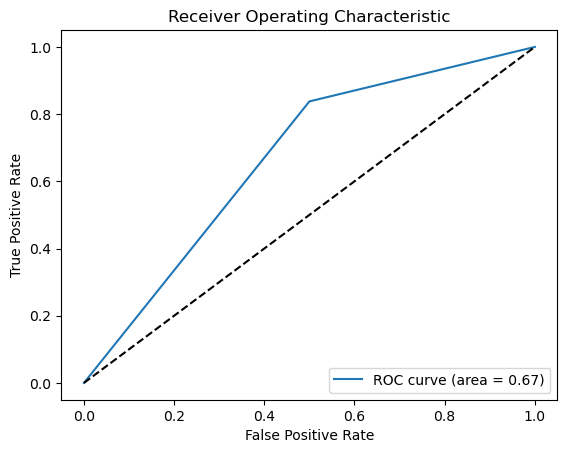

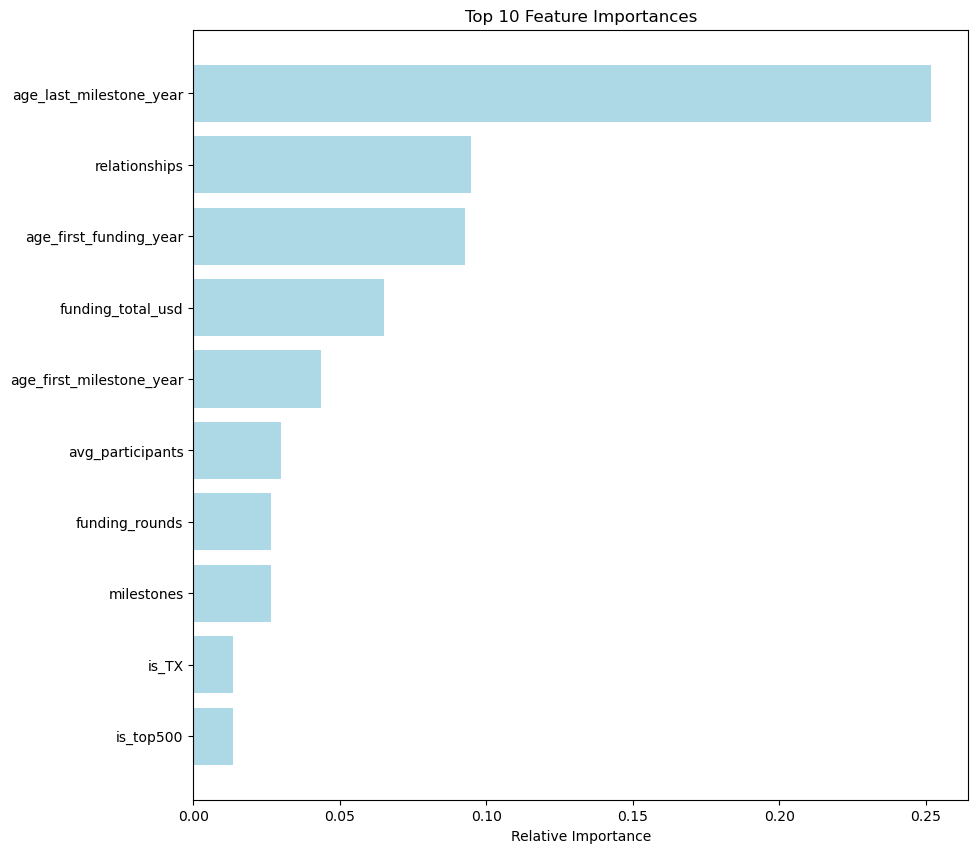

Cross-Validation Scores: [0.76612903 0.71544715 0.74796748 0.76422764 0.77235772]
Mean CV Accuracy: 0.7532258064516129


In [13]:
complete_CART=CART_classifier(X_train, y_train, X_test, y_test)

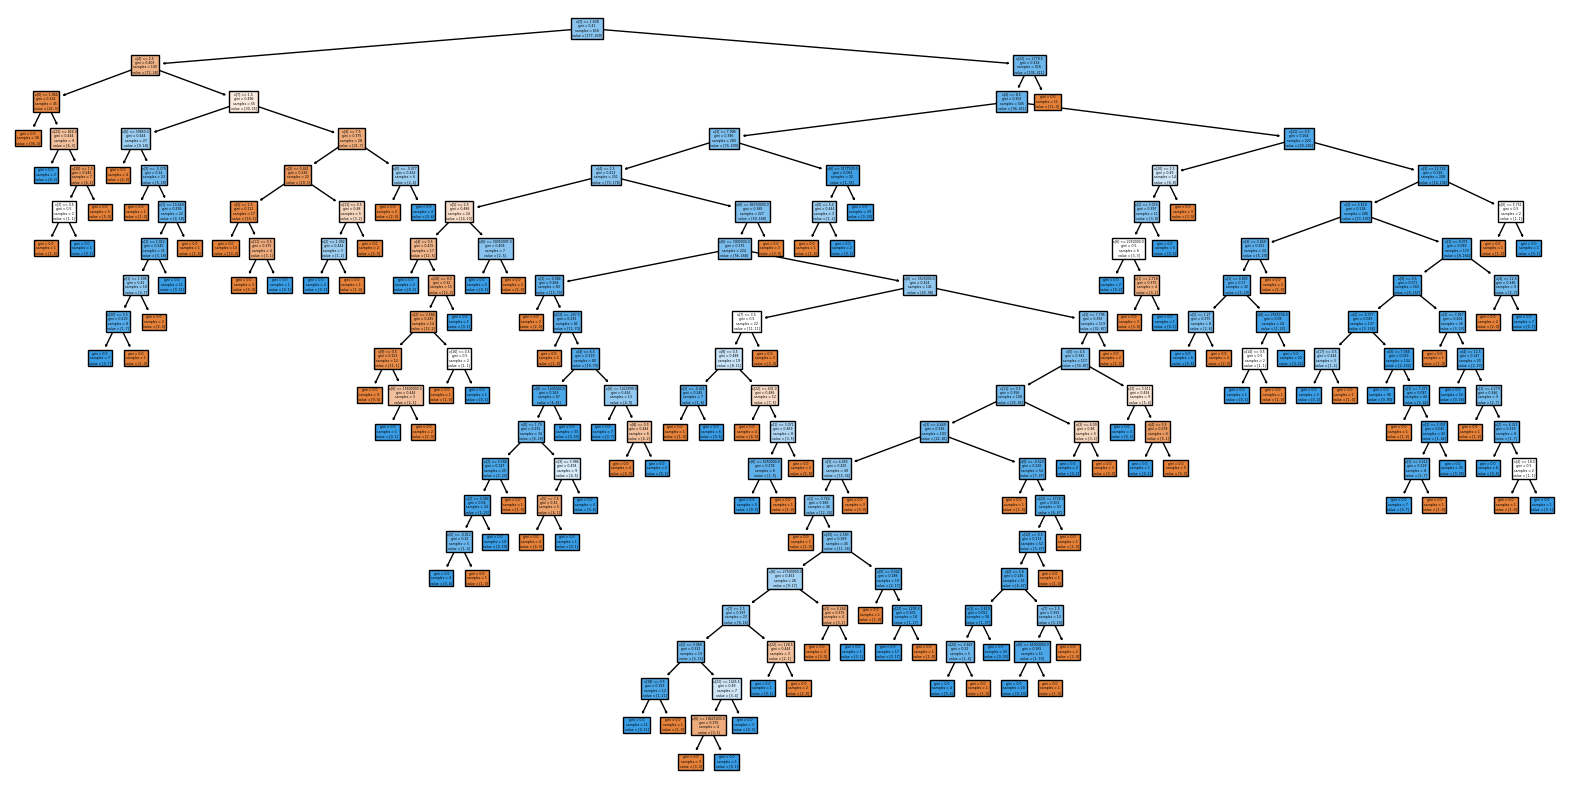

Accuracy: 0.7032258064516129
Confusion Matrix:
 [[22 22]
 [24 87]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.50      0.49        44
           1       0.80      0.78      0.79       111

    accuracy                           0.70       155
   macro avg       0.64      0.64      0.64       155
weighted avg       0.71      0.70      0.71       155

ROC AUC Score: 0.6418918918918919


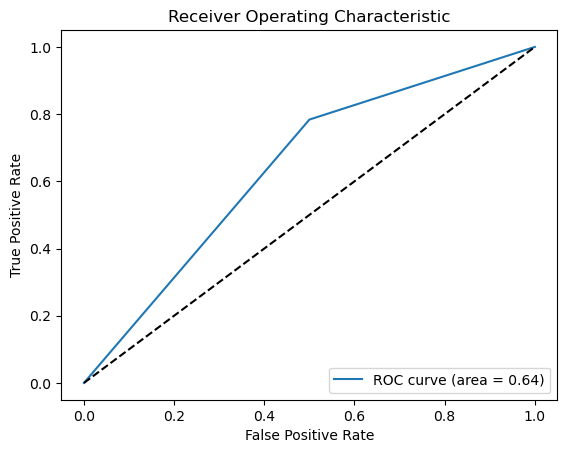

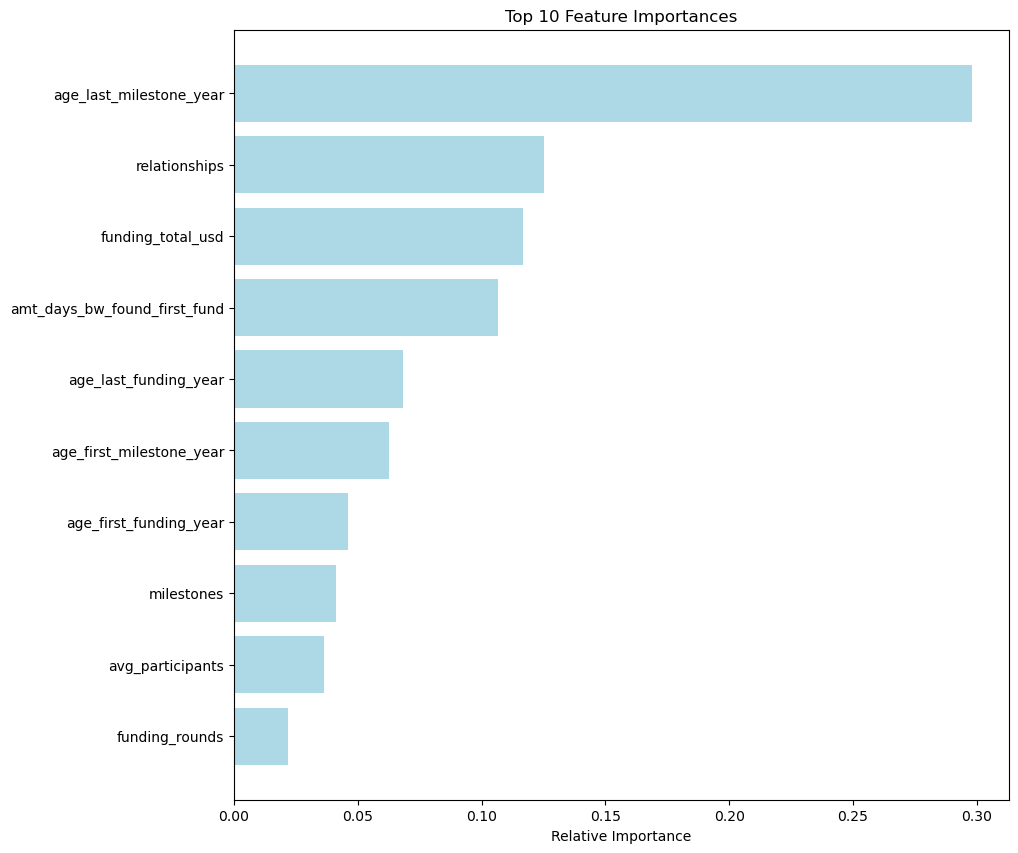

Cross-Validation Scores: [0.73387097 0.72357724 0.65853659 0.75609756 0.70731707]
Mean CV Accuracy: 0.7158798846052976


In [14]:
reduced_CART=CART_classifier(X_train_reduced, y_train, X_test_reduced, y_test)

## 4. Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


def rf_classifier(X_train, y_train, X_test, y_test):
    param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 4, 6, 8, 10]}
    
    grid_search = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid, cv = 5, scoring = 'accuracy')
    
    grid_search.fit(X_train, y_train)
    
    #best estimator from grid search
    best_rf_classifier = grid_search.best_estimator_
    
    y_pred = best_rf_classifier.predict(X_test)

    # Model Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Classification Report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # ROC-AUC (only for binary classification)
    if len(set(y_test)) == 2:
        y_pred_prob = best_rf_classifier.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("ROC AUC Score:", roc_auc)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate (Random Forest Model)')
        plt.ylabel('True Positive Rate (Random Forest Model)')
        plt.title('Receiver Operating Characteristic (Random Forest Model)')
        plt.legend(loc="lower right")
        plt.show()
    
    feature_importances = best_rf_classifier.feature_importances_
    indices = np.argsort(feature_importances)[-10:]  # Get the indices of the top features
    plt.figure(figsize=(10,10))
    plt.title('Top 10 Feature Importances (Random Forest Model)'.format(10))
    plt.barh(range(len(indices)), feature_importances[indices], color='lightblue', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    # Cross-Validation Scores
    cross_val_scores = cross_val_score(best_rf_classifier, X_train, y_train, cv=5)
    print("Cross-Validation Scores:", cross_val_scores)
    print("Mean CV Accuracy:", cross_val_scores.mean())

Accuracy: 0.7612903225806451
Confusion Matrix:
 [[ 12  32]
 [  5 106]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.27      0.39        44
           1       0.77      0.95      0.85       111

    accuracy                           0.76       155
   macro avg       0.74      0.61      0.62       155
weighted avg       0.75      0.76      0.72       155

ROC AUC Score: 0.7585995085995086


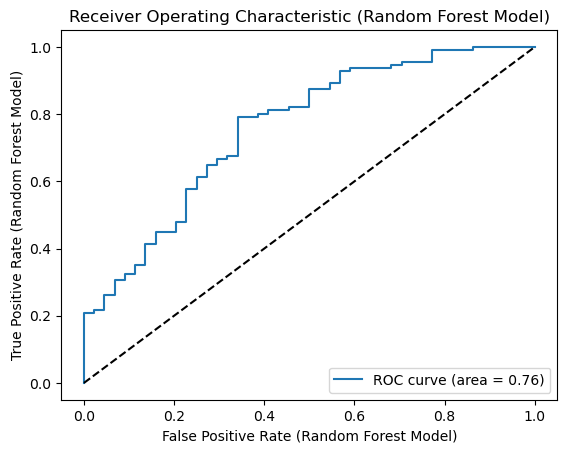

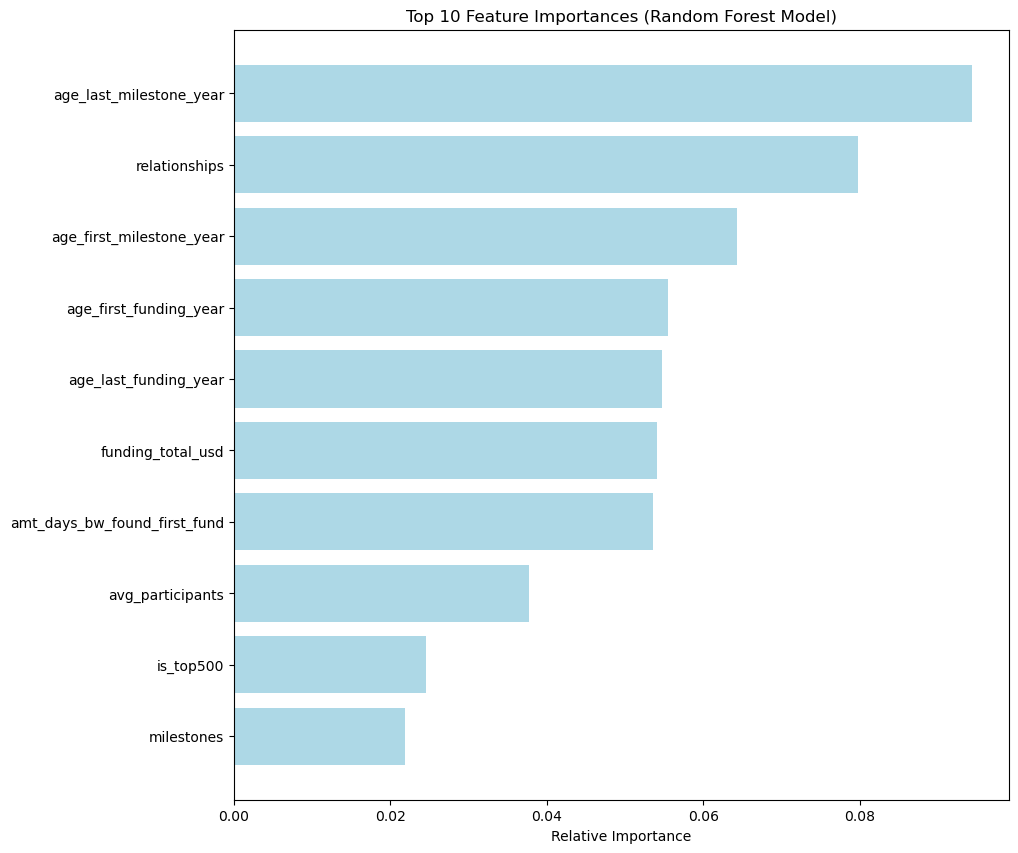

Cross-Validation Scores: [0.79032258 0.78861789 0.82113821 0.82113821 0.78861789]
Mean CV Accuracy: 0.8019669551534225


In [16]:
complete_rf=rf_classifier(X_train, y_train, X_test, y_test)

## 5. LightGBM

## 6. Support Vector Machines

In [17]:
from sklearn.svm import SVC

def svm_classifier(X_train, y_train, X_test, y_test):
    param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']}
    
    grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv = 5, scoring = 'accuracy')
    
    grid_search.fit(X_train, y_train)
    
    #best estimator from grid search
    best_svm_classifier = grid_search.best_estimator_
    
    y_pred = best_svm_classifier.predict(X_test)

    # Model Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Classification Report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # ROC-AUC (only for binary classification)
    if len(set(y_test)) == 2:
        y_pred_prob = best_svm_classifier.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("ROC AUC Score:", roc_auc)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate (Support Vector Machines Model)')
        plt.ylabel('True Positive Rate (Support Vector Machines Model)')
        plt.title('Receiver Operating Characteristic (Support Vector Machines Model)')
        plt.legend(loc="lower right")
        plt.show()
    
    feature_importances = best_svm_classifier.feature_importances_
    indices = np.argsort(feature_importances)[-10:]  # Get the indices of the top features
    plt.figure(figsize=(10,10))
    plt.title('Top 10 Feature Importances (Support Vector Machines Model)'.format(10))
    plt.barh(range(len(indices)), feature_importances[indices], color='lightblue', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    # Cross-Validation Scores
    cross_val_scores = cross_val_score(best_svm_classifier, X_train, y_train, cv=5)
    print("Cross-Validation Scores:", cross_val_scores)
    print("Mean CV Accuracy:", cross_val_scores.mean())

In [ ]:
complete_svm=svm_classifier(X_train, y_train, X_test, y_test)

## Extra Code - NOT needed?

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)  # Fit the model to train data
predictions = model.predict(X_test)  # Make predictions

In [ ]:
# Drop columns 
data_clean = data.drop(columns = ["Unnamed: 0", "latitude", "longitude", "id", "Unnamed: 6", "object_id", "labels", "state_code.1", "closed_at"])
data_clean.head()

In [ ]:
# Transform the "status" column into a binary outcome
data_clean["status"] = data_clean["status"]== "acquired"
data_clean.head()

In [ ]:
data_clean = pd.get_dummies(data_clean, columns=['city'], prefix='city')
data_clean = pd.get_dummies(data_clean, columns=['zip_code'], prefix='zip_code')
data_clean = data_clean.drop('state_code', axis=1)
data_clean = data_clean.drop('category_code', axis=1)

data_clean['founded_at'] = pd.to_datetime(data_clean['founded_at'])

data_clean['first_funding_at'] = pd.to_datetime(data_clean['first_funding_at'])
data_clean['last_funding_at'] = pd.to_datetime(data_clean['last_funding_at'])

data_clean['amt_days_bw_found_first_fund'] = (data_clean['first_funding_at'] - data_clean['founded_at']).dt.days
# data_clean['amt_days_bw_first_last_fund'] = (data_clean['last_funding_at'] - data_clean['first_funding_at']).dt.days

data_clean['status'] = data_clean['status'].apply(lambda x: 1 if x==True else 0)

data_clean['founding_month'] = data_clean['founded_at'].apply(lambda x: x.month)

data_clean = data_clean.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at'])

In [ ]:
data_clean.isna().sum()
data_clean['age_first_milestone_year']
data_clean = data_clean.dropna()
data_clean.shape
data_clean.isna().sum()

In [ ]:
df_all = data_clean.drop(columns=['name', 'founding_month']).copy()

X = df_all.copy()
X = X.drop(columns=['status'])
y = df_all['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

y_train.value_counts()
y_test.value_counts()

# Summary
GOAL = predict "status" given the other features

### Steps:
1. run first logistic regression to see first results
2. enforce sparsity through lasso regression (although lasso is not sparse lol)
3. retrieve main features 
4. build classification tree

### Results Visualization
Visualize all the above results to present findings

# Logistic Regression
### Split data into train and test
Maintaining the proportion of 1s

In [ ]:
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)

selected_features = list(X.columns[lasso_model.coef_[0] != 0])
coefficients = lasso_model.coef_[0][lasso_model.coef_[0] != 0]

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients
})

In [ ]:
columns_to_keep = [col for col in data_clean.columns if not col.startswith('city_') and not col.startswith('zip_code_')]
len(columns_to_keep)
columns_to_keep
list(data_clean.columns)[:33]
all_features = list(summary_df['Feature'])
columns_to_keep_lasso = [col for col in all_features if not col.startswith('city_') and not col.startswith('zip_code_')]
len(columns_to_keep_lasso)

In [ ]:
set(columns_to_keep) - set(columns_to_keep_lasso)
X_train_reduced = X_train[all_features]
X_test_reduced = X_test[all_features]
summary_df